# KNN, рак и спам
__Суммарное количество баллов: 12__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas
import typing

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщен
ий.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быь упорядочен случайно.

In [3]:
def read_cancer_dataset(path_to_csv: str) -> typing.Tuple[typing.List, typing.List]:
    data = pandas.read_csv(path_to_csv).values.tolist()
    random.shuffle(data)
    return [row[1:] for row in data], [(1 if row[0] == 'M' else 0) for row in data]


def read_spam_dataset(path_to_csv: str) -> typing.Tuple[typing.List, typing.List]:
    data = pandas.read_csv(path_to_csv).values.tolist()
    random.shuffle(data)
    return [row[:-1] for row in data], [int(row[-1]) for row in data]

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

In [4]:
def train_test_split(
        xs: typing.List,
        ys: typing.List,
        ratio: float
) -> typing.Tuple[typing.List, typing.List, typing.List, typing.List]:
    assert len(xs) == len(ys)
    train_size = int(ratio * len(xs))
    return xs[:train_size], ys[:train_size], xs[train_size:], ys[train_size:]


### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [5]:
def get_precision_recall_accuracy(y_pred: list, y_true: list) -> typing.Tuple[typing.List, typing.List, float]:
    assert len(y_pred) == len(y_true)
    n = len(y_pred)
    assert n > 0

    accuracy = sum(1 for yp, yt in zip(y_pred, y_true) if yp == yt) / n
    classes = set(y_true + y_pred)
    cn = len(classes)

    precision = [0.0] * cn
    recall = [0.0] * cn

    for i, y in enumerate(classes):
        tp = sum(1 for yp, yt in zip(y_pred, y_true) if yp == y and yt == y)  # true positive
        fp = sum(1 for yp, yt in zip(y_pred, y_true) if yp == y and yt != y)  # false positive
        fn = sum(1 for yp, yt in zip(y_pred, y_true) if yp != y and yt == y)  # false negative
        precision[i] = tp / (tp + fp)
        recall[i] = tp / (tp + fn)

    return precision, recall, accuracy


Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [6]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [7]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_probabilities(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [8]:
def get_dist(a: np.ndarray, b: np.ndarray):
    return np.linalg.norm(a - b)


class Point:

    def __init__(self, vector, i):
        self.vector = vector
        self.id = i

    def get_dist(self, o: np.ndarray):
        return get_dist(self.vector, o)


class Node:

    def __init__(
            self,
            axis: int,
            axis_value: float,
            points_number: int,
            left_son=None,
            right_son=None,
            points: typing.List[Point] = None
    ):
        self.axis = axis
        self.axis_value = axis_value
        self.points_number = points_number
        self.points = points
        self.left_son = left_son
        self.right_son = right_son

        self.box_center = np.array([])
        self.box_radius = 0

        self.build_boundaries()

    def build_boundaries(self):
        up_boundary = np.array([p.vector for p in self.points]).max(axis=0)
        down_boundary = np.array([p.vector for p in self.points]).min(axis=0)
        self.box_center = (down_boundary + up_boundary) / 2
        self.box_radius = get_dist(self.box_center, down_boundary)

    def check_intersection(self, center: np.ndarray, radius: float) -> bool:
        return get_dist(self.box_center, center) <= self.box_radius + radius


class KDTree:

    def build_tree(
            self,
            points: typing.List[Point],
            axis: int,
            dimension: int,
            leaf_size: int,
            depth: int = 0
    ) -> typing.Optional[Node]:
        if len(points) == 0:
            return None
        pivot = float(np.median(np.array([p.vector[axis] for p in points])))
        points_number = len(points)

        if points_number <= leaf_size:
            return Node(axis, pivot, points_number, points=points)

        points = [p for p in points if p.vector[axis] < pivot] +\
                 [p for p in points if p.vector[axis] == pivot] +\
                 [p for p in points if p.vector[axis] > pivot]

        left_part = points[:points_number // 2]
        right_part = points[points_number // 2:]

        left_son = self.build_tree(left_part, (axis + 1) % dimension, dimension, leaf_size, depth + 1)
        right_son = self.build_tree(right_part, (axis + 1) % dimension, dimension, leaf_size, depth + 1)

        return Node(axis, pivot, points_number, left_son, right_son, points)

    def __init__(self, points: np.ndarray, leaf_size: int = 40):
        points = [Point(vector, i) for i, vector in enumerate(points)]
        points_number = len(points)
        assert points_number > 0
        dimension = points[0].vector.shape[0]
        assert dimension > 0
        self.root = self.build_tree(points, 0, dimension, leaf_size)

    def find_circle_boundary(self, point: np.ndarray, node: Node, k: int):
        node_to = node.left_son if point[node.axis] < node.axis_value else node.right_son
        if node_to and node_to.points_number >= k:
            return self.find_circle_boundary(point, node_to, k)
        node.points.sort(key=lambda p: p.get_dist(point))
        return node.points[min(k, len(node.points)) - 1].get_dist(point), node.points[:min(k, len(node.points))]

    def update_knn(
            self,
            node: Node,
            current_knn: typing.List[Point],
            k: int,
            center: np.ndarray,
            radius: float
    ) -> typing.Tuple[float, typing.List[Point]]:
        if not node or not node.check_intersection(center, radius):
            return radius, current_knn
        if not node.left_son and not node.right_son:
            current_knn += node.points
            current_knn.sort(key=lambda p: p.get_dist(center))
            if k < len(current_knn):
                current_knn = current_knn[:k]
            radius = current_knn[-1].get_dist(center)
            return radius, current_knn
        radius, current_knn = self.update_knn(node.left_son, current_knn, k, center, radius)
        radius, current_knn = self.update_knn(node.right_son, current_knn, k, center, radius)
        return radius, current_knn

    def find_knn(self, point: np.ndarray, k: int) -> typing.List[Point]:
        assert self.root.points_number >= k
        radius, knn = self.find_circle_boundary(point, self.root, k)
        radius, knn = self.update_knn(self.root, [], k, point, radius)
        return knn

    def query(self, xs: np.ndarray, k=1, return_distance=True):
        if self.root.points_number >= k:
            result = [self.find_knn(x, k) for x in xs]
        else:
            result = [self.root.points for _ in xs]
        if return_distance:
            return [[(p.id, p.get_dist(xs[i])) for p in knn] for i, knn in enumerate(result)]
        else:
            return [[p.id for p in knn] for knn in result]


Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [9]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4, return_distance=False)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_probabilities` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [10]:
class KNearest:

    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        self.k = n_neighbors
        self.leaf_size = leaf_size
        self.kd_tree = None
        self.labels = None
        self.ys = None

    def fit(self, xs: list, ys: list):
        self.kd_tree = KDTree(np.array(xs), self.leaf_size)
        self.ys = ys
        self.labels = list(set(ys))

    def predict_probabilities(self, xs: list) -> np.ndarray:
        predicted_ys = self.kd_tree.query(xs, self.k, False)
        ps = [[]] * len(xs)
        for i in range(len(xs)):
            ps[i] = [0.0] * len(self.labels)
            for y in predicted_ys[i]:
                ps[i][self.ys[y]] += 1
            ps[i] = [p / len(predicted_ys[i]) for p in ps[i]]
        return np.array(ps)

    def predict(self, xs: list):
        return np.argmax(self.predict_probabilities(xs), axis=1).tolist()


Наконец, протестируем наш классификатор на различных наборах данных

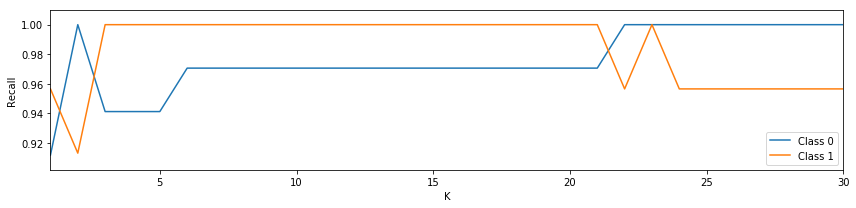

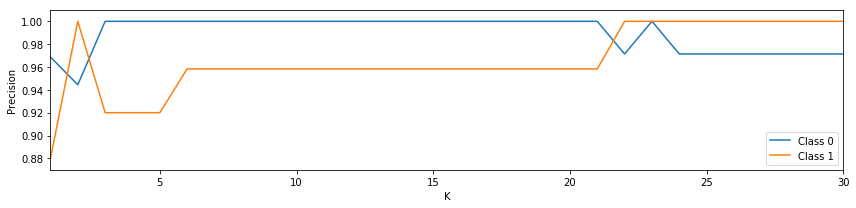

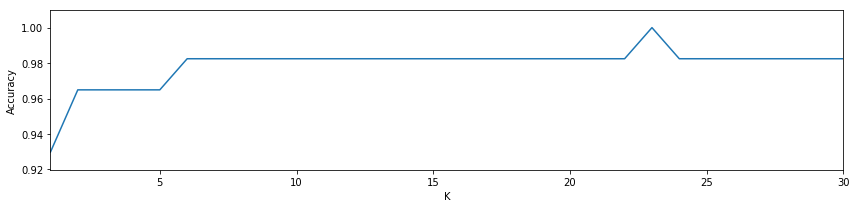

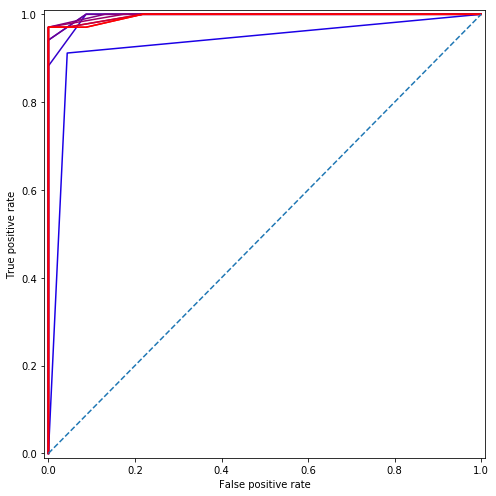

In [11]:
X, y = read_cancer_dataset("resources/cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

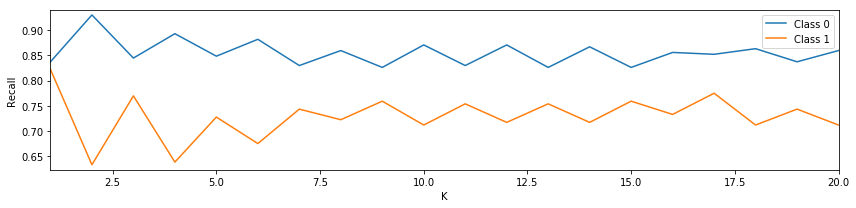

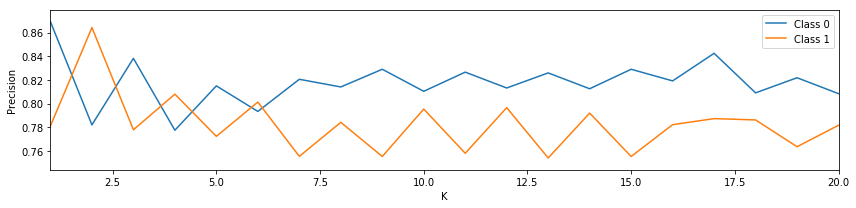

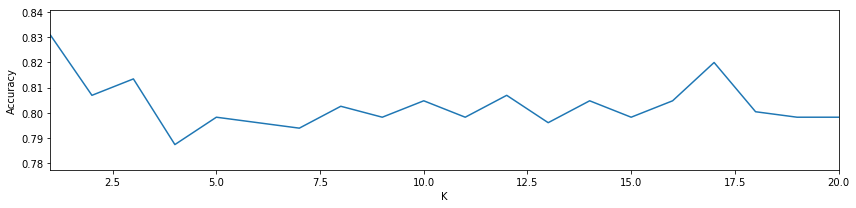

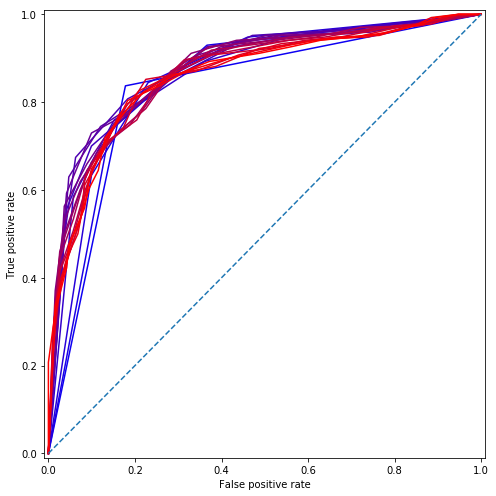

In [12]:
X, y = read_spam_dataset("resources/spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)

## Добавим нормализацию и посмотрим на результат

In [28]:
def standard_scale(xs: list) -> list:
    mean = np.mean(np.array(xs))
    std = np.std(np.array(xs))
    return [(x - mean) / std for x in xs]


# scale [min, max] to [0, 1]
def zero_one_scale(xs: list) -> list:
    m = np.array(xs).min()
    M = np.array(xs).max()
    return [(x - m) / (M - m) for x in xs]


def max_abs_scale(xs: list) -> list:
    m = np.array([abs(x) for x in xs]).max()
    return [x / m for x in xs]


## Cancer

### Standart

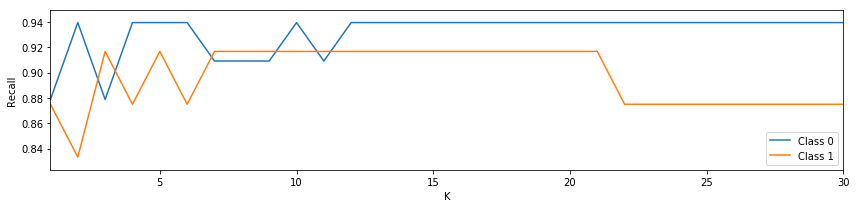

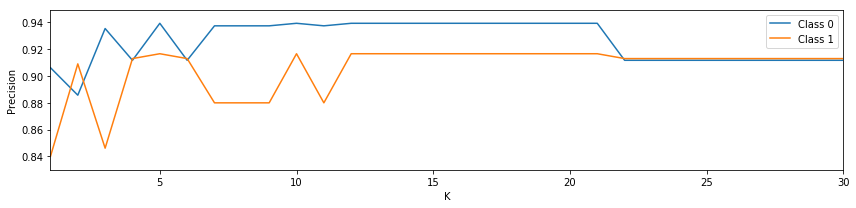

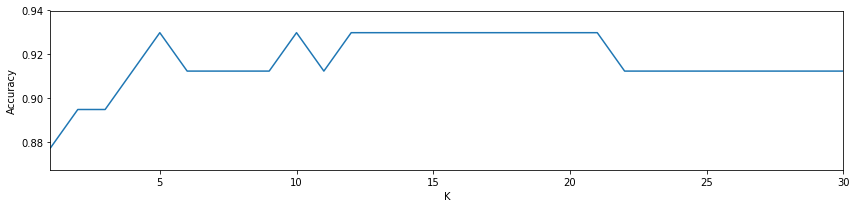

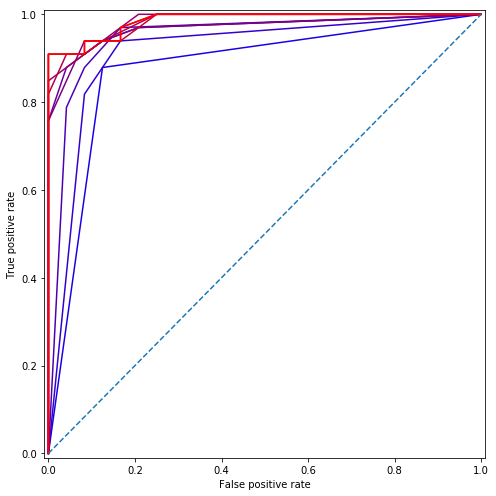

In [18]:
X, y = read_cancer_dataset("resources/cancer.csv")
X = standard_scale(X)
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

Стало хуже

### Zero One Scale

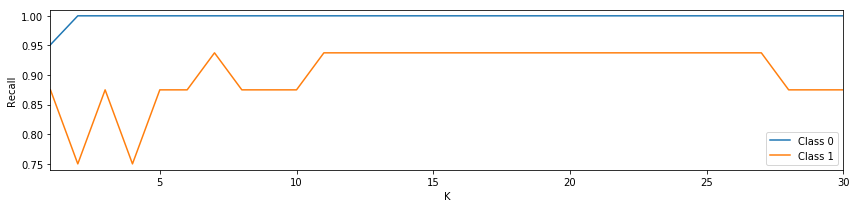

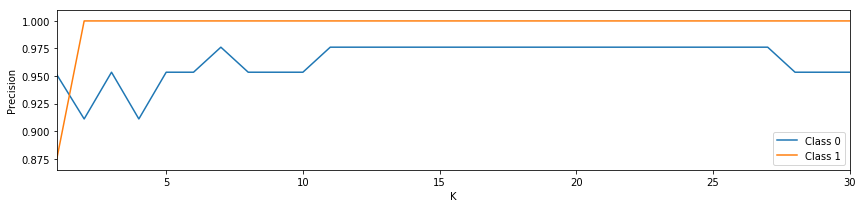

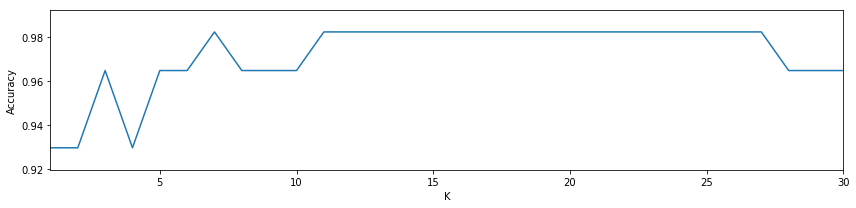

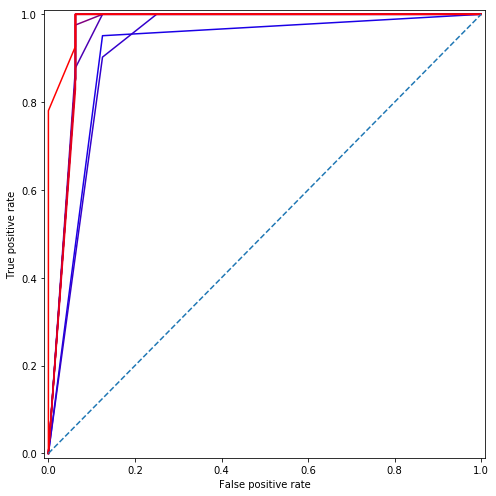

In [26]:
X, y = read_cancer_dataset("resources/cancer.csv")
X = zero_one_scale(X)
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

Для одного класса стало заметно лучше, для другого немного хуже

### Max Abs Scale

In [29]:
X, y = read_cancer_dataset("resources/cancer.csv")
X = max_abs_scale(X)
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

TypeError: bad operand type for abs(): 'list'